# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

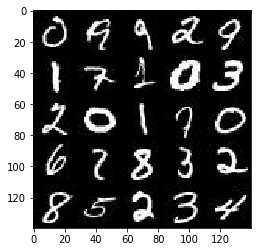

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

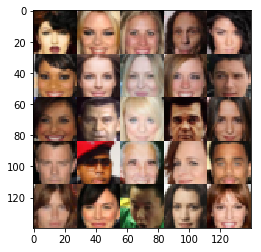

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,[None,image_width, image_height, image_channels], name = 'real_input')
    z_input = tf.placeholder(tf.float32,[None, z_dim], name = 'z_input')
    learning_rate = tf.placeholder(tf.float32,[], name = 'learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.05
        keep_prob = 0.6
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        drop0 = tf.layers.dropout(x1, keep_prob)

        
        x2 = tf.layers.conv2d(drop0, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        drop1 = tf.layers.dropout(x2, keep_prob)

        
        x3 = tf.layers.conv2d(drop1, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        drop2 = tf.layers.dropout(x3, keep_prob)


        flat = tf.reshape(drop2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.1
        keep_prob = 0.5
        x1 = tf.layers.dense(z, 4*4*1024)
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = x1*tf.sigmoid(x1) #swish
        drop0 = tf.layers.dropout(x1, keep_prob, training=is_train)

        x2 = tf.layers.conv2d_transpose(drop0, 512, 4, 1, 'valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = x2*tf.sigmoid(x2)
        drop1 = tf.layers.dropout(x2, keep_prob, training=is_train)

        x3 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = x3*tf.sigmoid(x3)
        drop2 = tf.layers.dropout(x3, keep_prob, training=is_train)
        
        x4 = tf.layers.conv2d_transpose(drop1, 128, 5, 2, 'same')
        x4 = tf.layers.batch_normalization(x3, training=is_train)
        x4 = x4*tf.sigmoid(x4)
        drop3 = tf.layers.dropout(x4, keep_prob, training=is_train)
        
        

        # Output layer, 28x28xn
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, 2, 'same')

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    dis_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]

    
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)


    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = 1
    if(data_image_mode == 'RGB'):
        image_channels = 3
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    learn_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, image_channels )
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Give Generator an Advantage
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
        
                
                if (steps%100 == 0):
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                if (steps%10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("\n Epoch {}/{} Step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))   
                    
            
            # At the end of each epoch, get the losses and print them out
            train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("\n Epoch {}/{}...".format(epoch_i+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))    
           

                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


 Epoch 1/2 Step 10 Discriminator Loss: 2.9073... Generator Loss: 0.1209

 Epoch 1/2 Step 20 Discriminator Loss: 2.4687... Generator Loss: 0.2056

 Epoch 1/2 Step 30 Discriminator Loss: 2.7883... Generator Loss: 0.1110

 Epoch 1/2 Step 40 Discriminator Loss: 2.0400... Generator Loss: 1.0260

 Epoch 1/2 Step 50 Discriminator Loss: 1.8885... Generator Loss: 0.4142

 Epoch 1/2 Step 60 Discriminator Loss: 1.9663... Generator Loss: 0.4233

 Epoch 1/2 Step 70 Discriminator Loss: 1.5117... Generator Loss: 0.9800

 Epoch 1/2 Step 80 Discriminator Loss: 1.5522... Generator Loss: 0.8751

 Epoch 1/2 Step 90 Discriminator Loss: 1.3972... Generator Loss: 1.0793


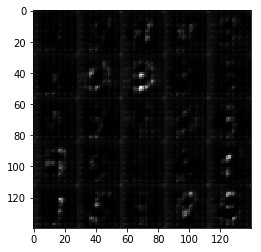


 Epoch 1/2 Step 100 Discriminator Loss: 1.4294... Generator Loss: 0.5696

 Epoch 1/2 Step 110 Discriminator Loss: 1.5589... Generator Loss: 1.4844

 Epoch 1/2 Step 120 Discriminator Loss: 1.6184... Generator Loss: 0.4663

 Epoch 1/2 Step 130 Discriminator Loss: 1.4202... Generator Loss: 0.6265

 Epoch 1/2 Step 140 Discriminator Loss: 1.6915... Generator Loss: 0.3400

 Epoch 1/2 Step 150 Discriminator Loss: 1.5276... Generator Loss: 0.5084

 Epoch 1/2 Step 160 Discriminator Loss: 1.3180... Generator Loss: 0.6623

 Epoch 1/2 Step 170 Discriminator Loss: 1.5101... Generator Loss: 0.7926

 Epoch 1/2 Step 180 Discriminator Loss: 1.2486... Generator Loss: 0.7757

 Epoch 1/2 Step 190 Discriminator Loss: 1.2800... Generator Loss: 0.7037


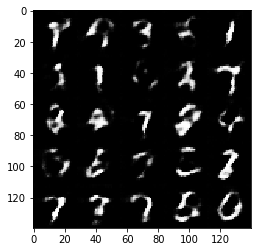


 Epoch 1/2 Step 200 Discriminator Loss: 1.2902... Generator Loss: 1.1057

 Epoch 1/2 Step 210 Discriminator Loss: 1.2329... Generator Loss: 1.0984

 Epoch 1/2 Step 220 Discriminator Loss: 1.4817... Generator Loss: 0.4178

 Epoch 1/2 Step 230 Discriminator Loss: 1.3149... Generator Loss: 0.9015

 Epoch 1/2 Step 240 Discriminator Loss: 1.2557... Generator Loss: 0.7557

 Epoch 1/2 Step 250 Discriminator Loss: 1.2628... Generator Loss: 0.8479

 Epoch 1/2 Step 260 Discriminator Loss: 1.3455... Generator Loss: 0.7300

 Epoch 1/2 Step 270 Discriminator Loss: 1.4529... Generator Loss: 0.6805

 Epoch 1/2 Step 280 Discriminator Loss: 1.5042... Generator Loss: 1.5020

 Epoch 1/2 Step 290 Discriminator Loss: 1.2829... Generator Loss: 1.0464


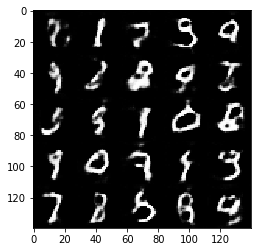


 Epoch 1/2 Step 300 Discriminator Loss: 1.3549... Generator Loss: 0.5801

 Epoch 1/2 Step 310 Discriminator Loss: 1.0592... Generator Loss: 1.1109

 Epoch 1/2 Step 320 Discriminator Loss: 1.2680... Generator Loss: 1.1177

 Epoch 1/2 Step 330 Discriminator Loss: 1.3175... Generator Loss: 0.6636

 Epoch 1/2 Step 340 Discriminator Loss: 1.1952... Generator Loss: 0.9624

 Epoch 1/2 Step 350 Discriminator Loss: 1.3809... Generator Loss: 1.4876

 Epoch 1/2 Step 360 Discriminator Loss: 1.2737... Generator Loss: 0.9518

 Epoch 1/2 Step 370 Discriminator Loss: 1.3368... Generator Loss: 0.5168

 Epoch 1/2 Step 380 Discriminator Loss: 1.3645... Generator Loss: 0.5658

 Epoch 1/2 Step 390 Discriminator Loss: 1.4165... Generator Loss: 0.6770


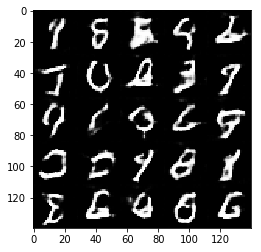


 Epoch 1/2 Step 400 Discriminator Loss: 1.1614... Generator Loss: 0.9441

 Epoch 1/2 Step 410 Discriminator Loss: 1.3162... Generator Loss: 0.8757

 Epoch 1/2 Step 420 Discriminator Loss: 1.3766... Generator Loss: 0.6442

 Epoch 1/2 Step 430 Discriminator Loss: 1.0579... Generator Loss: 1.2151

 Epoch 1/2 Step 440 Discriminator Loss: 1.2590... Generator Loss: 1.1414

 Epoch 1/2 Step 450 Discriminator Loss: 1.1652... Generator Loss: 0.8934

 Epoch 1/2 Step 460 Discriminator Loss: 1.4201... Generator Loss: 0.5607

 Epoch 1/2 Step 470 Discriminator Loss: 1.6675... Generator Loss: 0.4159

 Epoch 1/2 Step 480 Discriminator Loss: 1.2846... Generator Loss: 0.5913

 Epoch 1/2 Step 490 Discriminator Loss: 1.4600... Generator Loss: 0.4715


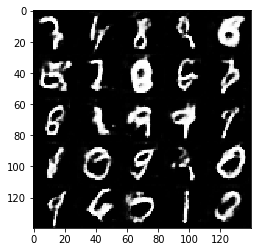


 Epoch 1/2 Step 500 Discriminator Loss: 1.3428... Generator Loss: 0.8815

 Epoch 1/2 Step 510 Discriminator Loss: 1.7395... Generator Loss: 2.2323

 Epoch 1/2 Step 520 Discriminator Loss: 1.1368... Generator Loss: 1.0205

 Epoch 1/2 Step 530 Discriminator Loss: 1.1740... Generator Loss: 0.7363

 Epoch 1/2 Step 540 Discriminator Loss: 1.4222... Generator Loss: 0.4800

 Epoch 1/2 Step 550 Discriminator Loss: 1.1542... Generator Loss: 0.9172

 Epoch 1/2 Step 560 Discriminator Loss: 1.0775... Generator Loss: 1.3672

 Epoch 1/2 Step 570 Discriminator Loss: 1.3516... Generator Loss: 0.5947

 Epoch 1/2 Step 580 Discriminator Loss: 1.1665... Generator Loss: 1.0227

 Epoch 1/2 Step 590 Discriminator Loss: 1.1381... Generator Loss: 0.8760


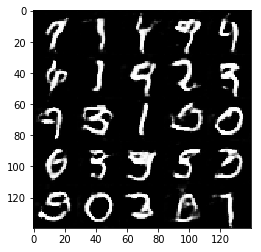


 Epoch 1/2 Step 600 Discriminator Loss: 1.1739... Generator Loss: 0.8128

 Epoch 1/2 Step 610 Discriminator Loss: 1.1728... Generator Loss: 0.6793

 Epoch 1/2 Step 620 Discriminator Loss: 1.1111... Generator Loss: 0.8222

 Epoch 1/2 Step 630 Discriminator Loss: 1.3172... Generator Loss: 0.5849

 Epoch 1/2 Step 640 Discriminator Loss: 1.0500... Generator Loss: 0.9513

 Epoch 1/2 Step 650 Discriminator Loss: 1.3891... Generator Loss: 0.4563

 Epoch 1/2 Step 660 Discriminator Loss: 1.0065... Generator Loss: 1.0641

 Epoch 1/2 Step 670 Discriminator Loss: 1.2387... Generator Loss: 0.8163

 Epoch 1/2 Step 680 Discriminator Loss: 1.3228... Generator Loss: 0.5334

 Epoch 1/2 Step 690 Discriminator Loss: 1.0124... Generator Loss: 1.3154


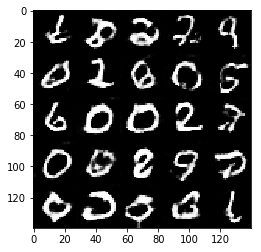


 Epoch 1/2 Step 700 Discriminator Loss: 1.0527... Generator Loss: 0.9159

 Epoch 1/2 Step 710 Discriminator Loss: 1.0932... Generator Loss: 2.0495

 Epoch 1/2 Step 720 Discriminator Loss: 2.6305... Generator Loss: 3.8811

 Epoch 1/2 Step 730 Discriminator Loss: 1.0363... Generator Loss: 0.9511

 Epoch 1/2 Step 740 Discriminator Loss: 0.9217... Generator Loss: 1.2874

 Epoch 1/2 Step 750 Discriminator Loss: 1.0020... Generator Loss: 1.4312

 Epoch 1/2 Step 760 Discriminator Loss: 1.2859... Generator Loss: 0.6237

 Epoch 1/2 Step 770 Discriminator Loss: 1.0466... Generator Loss: 0.7301

 Epoch 1/2 Step 780 Discriminator Loss: 0.9914... Generator Loss: 1.9062

 Epoch 1/2 Step 790 Discriminator Loss: 0.8015... Generator Loss: 0.9845


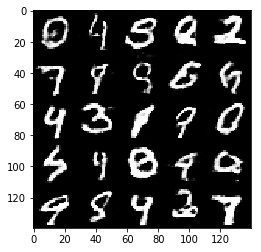


 Epoch 1/2 Step 800 Discriminator Loss: 0.9444... Generator Loss: 1.1884

 Epoch 1/2 Step 810 Discriminator Loss: 1.0362... Generator Loss: 0.7504

 Epoch 1/2 Step 820 Discriminator Loss: 1.0130... Generator Loss: 1.8341

 Epoch 1/2 Step 830 Discriminator Loss: 0.8788... Generator Loss: 0.9450

 Epoch 1/2 Step 840 Discriminator Loss: 1.4317... Generator Loss: 2.2740

 Epoch 1/2 Step 850 Discriminator Loss: 0.8419... Generator Loss: 1.2872

 Epoch 1/2 Step 860 Discriminator Loss: 0.8644... Generator Loss: 1.2457

 Epoch 1/2 Step 870 Discriminator Loss: 1.1298... Generator Loss: 0.7860

 Epoch 1/2 Step 880 Discriminator Loss: 0.8143... Generator Loss: 1.1815

 Epoch 1/2 Step 890 Discriminator Loss: 0.7666... Generator Loss: 1.4295


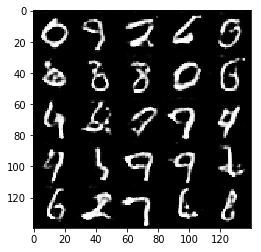


 Epoch 1/2 Step 900 Discriminator Loss: 1.0049... Generator Loss: 0.9975

 Epoch 1/2 Step 910 Discriminator Loss: 0.9590... Generator Loss: 1.4229

 Epoch 1/2 Step 920 Discriminator Loss: 1.0199... Generator Loss: 0.8747

 Epoch 1/2 Step 930 Discriminator Loss: 0.8491... Generator Loss: 1.2073

 Epoch 1/2 Step 940 Discriminator Loss: 1.0258... Generator Loss: 1.0216

 Epoch 1/2 Step 950 Discriminator Loss: 1.1042... Generator Loss: 0.6024

 Epoch 1/2 Step 960 Discriminator Loss: 1.1318... Generator Loss: 1.9136

 Epoch 1/2 Step 970 Discriminator Loss: 1.1648... Generator Loss: 0.7882

 Epoch 1/2 Step 980 Discriminator Loss: 0.8719... Generator Loss: 1.3416

 Epoch 1/2 Step 990 Discriminator Loss: 0.7653... Generator Loss: 1.5433


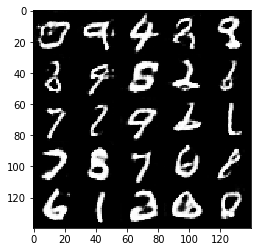


 Epoch 1/2 Step 1000 Discriminator Loss: 0.9170... Generator Loss: 1.5474

 Epoch 1/2 Step 1010 Discriminator Loss: 1.1614... Generator Loss: 1.6682

 Epoch 1/2 Step 1020 Discriminator Loss: 0.9106... Generator Loss: 1.1805

 Epoch 1/2 Step 1030 Discriminator Loss: 1.0124... Generator Loss: 0.8004

 Epoch 1/2 Step 1040 Discriminator Loss: 1.3353... Generator Loss: 0.5671

 Epoch 1/2 Step 1050 Discriminator Loss: 0.8842... Generator Loss: 1.3344

 Epoch 1/2 Step 1060 Discriminator Loss: 1.1394... Generator Loss: 0.6247

 Epoch 1/2 Step 1070 Discriminator Loss: 0.7823... Generator Loss: 1.3362

 Epoch 1/2 Step 1080 Discriminator Loss: 0.9006... Generator Loss: 0.7119

 Epoch 1/2 Step 1090 Discriminator Loss: 1.0252... Generator Loss: 1.1640


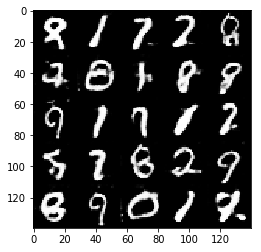


 Epoch 1/2 Step 1100 Discriminator Loss: 1.1119... Generator Loss: 0.8544

 Epoch 1/2 Step 1110 Discriminator Loss: 1.0527... Generator Loss: 1.4049

 Epoch 1/2 Step 1120 Discriminator Loss: 0.8103... Generator Loss: 1.4231

 Epoch 1/2 Step 1130 Discriminator Loss: 0.7556... Generator Loss: 1.4231

 Epoch 1/2 Step 1140 Discriminator Loss: 0.8920... Generator Loss: 1.0279

 Epoch 1/2 Step 1150 Discriminator Loss: 0.9712... Generator Loss: 1.0111

 Epoch 1/2 Step 1160 Discriminator Loss: 0.7933... Generator Loss: 1.9265

 Epoch 1/2 Step 1170 Discriminator Loss: 0.8219... Generator Loss: 1.1127

 Epoch 1/2 Step 1180 Discriminator Loss: 0.9681... Generator Loss: 0.8874

 Epoch 1/2 Step 1190 Discriminator Loss: 0.9453... Generator Loss: 1.0533


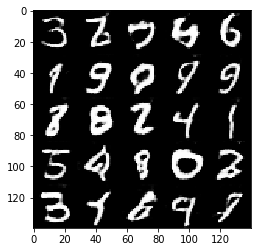


 Epoch 1/2 Step 1200 Discriminator Loss: 1.0407... Generator Loss: 0.7952

 Epoch 1/2 Step 1210 Discriminator Loss: 0.9531... Generator Loss: 1.0079

 Epoch 1/2 Step 1220 Discriminator Loss: 1.3962... Generator Loss: 0.5360

 Epoch 1/2 Step 1230 Discriminator Loss: 0.7922... Generator Loss: 1.4779

 Epoch 1/2 Step 1240 Discriminator Loss: 0.7477... Generator Loss: 1.3096

 Epoch 1/2 Step 1250 Discriminator Loss: 1.2381... Generator Loss: 0.6459

 Epoch 1/2 Step 1260 Discriminator Loss: 1.4679... Generator Loss: 0.5054

 Epoch 1/2 Step 1270 Discriminator Loss: 0.6957... Generator Loss: 1.7189

 Epoch 1/2 Step 1280 Discriminator Loss: 0.6328... Generator Loss: 2.3809

 Epoch 1/2 Step 1290 Discriminator Loss: 0.9590... Generator Loss: 0.9971


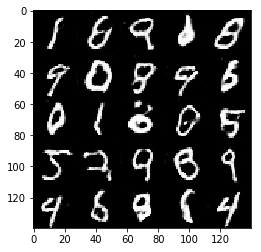


 Epoch 1/2 Step 1300 Discriminator Loss: 1.7068... Generator Loss: 3.6220

 Epoch 1/2 Step 1310 Discriminator Loss: 0.8663... Generator Loss: 1.0545

 Epoch 1/2 Step 1320 Discriminator Loss: 1.0912... Generator Loss: 0.7991

 Epoch 1/2 Step 1330 Discriminator Loss: 0.5352... Generator Loss: 1.9231

 Epoch 1/2 Step 1340 Discriminator Loss: 0.7251... Generator Loss: 1.7042

 Epoch 1/2 Step 1350 Discriminator Loss: 0.7297... Generator Loss: 1.1566

 Epoch 1/2 Step 1360 Discriminator Loss: 1.1741... Generator Loss: 0.7122

 Epoch 1/2 Step 1370 Discriminator Loss: 0.8301... Generator Loss: 1.8280

 Epoch 1/2 Step 1380 Discriminator Loss: 1.4715... Generator Loss: 0.6393

 Epoch 1/2 Step 1390 Discriminator Loss: 0.7606... Generator Loss: 1.2270


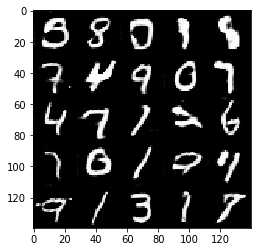


 Epoch 1/2 Step 1400 Discriminator Loss: 0.6782... Generator Loss: 1.6977

 Epoch 1/2 Step 1410 Discriminator Loss: 0.6332... Generator Loss: 1.7437

 Epoch 1/2 Step 1420 Discriminator Loss: 0.6536... Generator Loss: 1.8830

 Epoch 1/2 Step 1430 Discriminator Loss: 0.8143... Generator Loss: 1.5027

 Epoch 1/2 Step 1440 Discriminator Loss: 1.0916... Generator Loss: 0.8976

 Epoch 1/2 Step 1450 Discriminator Loss: 1.0044... Generator Loss: 0.8925

 Epoch 1/2 Step 1460 Discriminator Loss: 0.7572... Generator Loss: 1.2655

 Epoch 1/2 Step 1470 Discriminator Loss: 0.6773... Generator Loss: 1.5643

 Epoch 1/2 Step 1480 Discriminator Loss: 0.5317... Generator Loss: 2.0561

 Epoch 1/2 Step 1490 Discriminator Loss: 0.6310... Generator Loss: 2.4556


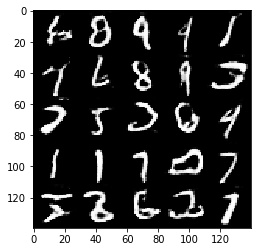


 Epoch 1/2 Step 1500 Discriminator Loss: 0.6926... Generator Loss: 1.5006

 Epoch 1/2 Step 1510 Discriminator Loss: 0.6788... Generator Loss: 1.1150

 Epoch 1/2 Step 1520 Discriminator Loss: 1.0653... Generator Loss: 0.9340

 Epoch 1/2 Step 1530 Discriminator Loss: 0.7475... Generator Loss: 1.4089

 Epoch 1/2 Step 1540 Discriminator Loss: 0.8922... Generator Loss: 1.2392

 Epoch 1/2 Step 1550 Discriminator Loss: 1.3071... Generator Loss: 0.6054

 Epoch 1/2 Step 1560 Discriminator Loss: 0.7477... Generator Loss: 1.4821

 Epoch 1/2 Step 1570 Discriminator Loss: 1.3579... Generator Loss: 0.5957

 Epoch 1/2 Step 1580 Discriminator Loss: 0.7306... Generator Loss: 1.5459

 Epoch 1/2 Step 1590 Discriminator Loss: 1.0674... Generator Loss: 0.8222


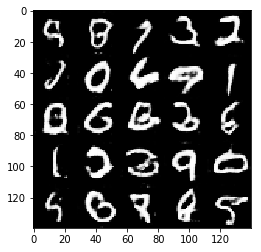


 Epoch 1/2 Step 1600 Discriminator Loss: 1.2933... Generator Loss: 0.5543

 Epoch 1/2 Step 1610 Discriminator Loss: 0.9484... Generator Loss: 0.7823

 Epoch 1/2 Step 1620 Discriminator Loss: 0.5565... Generator Loss: 1.9123

 Epoch 1/2 Step 1630 Discriminator Loss: 0.6386... Generator Loss: 2.2508

 Epoch 1/2 Step 1640 Discriminator Loss: 0.8297... Generator Loss: 1.1284

 Epoch 1/2 Step 1650 Discriminator Loss: 0.6377... Generator Loss: 1.4078

 Epoch 1/2 Step 1660 Discriminator Loss: 0.5540... Generator Loss: 1.9310

 Epoch 1/2 Step 1670 Discriminator Loss: 0.4966... Generator Loss: 2.8387

 Epoch 1/2 Step 1680 Discriminator Loss: 0.7773... Generator Loss: 1.1268

 Epoch 1/2 Step 1690 Discriminator Loss: 0.6802... Generator Loss: 1.6034


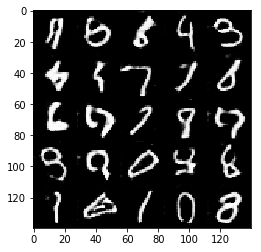


 Epoch 1/2 Step 1700 Discriminator Loss: 1.8091... Generator Loss: 0.4412

 Epoch 1/2 Step 1710 Discriminator Loss: 0.7366... Generator Loss: 2.3093

 Epoch 1/2 Step 1720 Discriminator Loss: 0.5982... Generator Loss: 1.2761

 Epoch 1/2 Step 1730 Discriminator Loss: 0.7393... Generator Loss: 1.8755

 Epoch 1/2 Step 1740 Discriminator Loss: 0.6170... Generator Loss: 2.0735

 Epoch 1/2 Step 1750 Discriminator Loss: 0.5128... Generator Loss: 2.7748

 Epoch 1/2 Step 1760 Discriminator Loss: 0.4838... Generator Loss: 2.2906

 Epoch 1/2 Step 1770 Discriminator Loss: 1.1501... Generator Loss: 0.7422

 Epoch 1/2 Step 1780 Discriminator Loss: 0.5329... Generator Loss: 2.0978

 Epoch 1/2 Step 1790 Discriminator Loss: 0.7362... Generator Loss: 1.2370


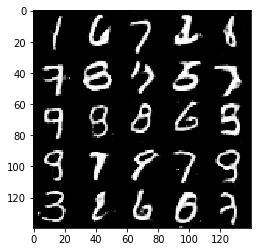


 Epoch 1/2 Step 1800 Discriminator Loss: 1.5980... Generator Loss: 3.8309

 Epoch 1/2 Step 1810 Discriminator Loss: 0.9291... Generator Loss: 1.0629

 Epoch 1/2 Step 1820 Discriminator Loss: 0.7054... Generator Loss: 1.3697

 Epoch 1/2 Step 1830 Discriminator Loss: 0.5865... Generator Loss: 1.6626

 Epoch 1/2 Step 1840 Discriminator Loss: 0.6040... Generator Loss: 1.5922

 Epoch 1/2 Step 1850 Discriminator Loss: 0.8297... Generator Loss: 1.3403

 Epoch 1/2 Step 1860 Discriminator Loss: 0.5816... Generator Loss: 1.9015

 Epoch 1/2 Step 1870 Discriminator Loss: 2.9374... Generator Loss: 6.1660

 Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 2.1507

 Epoch 2/2 Step 1880 Discriminator Loss: 0.5961... Generator Loss: 1.6324

 Epoch 2/2 Step 1890 Discriminator Loss: 0.9832... Generator Loss: 0.9046


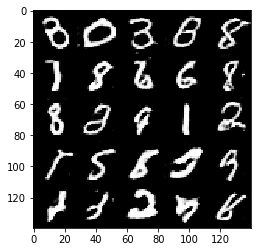


 Epoch 2/2 Step 1900 Discriminator Loss: 0.5315... Generator Loss: 1.8502

 Epoch 2/2 Step 1910 Discriminator Loss: 0.5737... Generator Loss: 2.9325

 Epoch 2/2 Step 1920 Discriminator Loss: 0.5294... Generator Loss: 2.0281

 Epoch 2/2 Step 1930 Discriminator Loss: 1.1475... Generator Loss: 2.5726

 Epoch 2/2 Step 1940 Discriminator Loss: 0.8830... Generator Loss: 1.4996

 Epoch 2/2 Step 1950 Discriminator Loss: 0.6695... Generator Loss: 1.7103

 Epoch 2/2 Step 1960 Discriminator Loss: 0.5731... Generator Loss: 2.1713

 Epoch 2/2 Step 1970 Discriminator Loss: 0.4853... Generator Loss: 2.6044

 Epoch 2/2 Step 1980 Discriminator Loss: 0.5508... Generator Loss: 2.0655

 Epoch 2/2 Step 1990 Discriminator Loss: 0.5766... Generator Loss: 2.9192


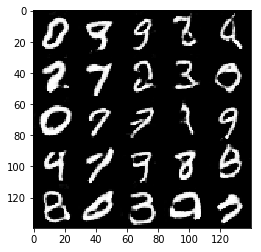


 Epoch 2/2 Step 2000 Discriminator Loss: 0.5050... Generator Loss: 2.7261

 Epoch 2/2 Step 2010 Discriminator Loss: 0.6914... Generator Loss: 1.6158

 Epoch 2/2 Step 2020 Discriminator Loss: 0.4513... Generator Loss: 3.0610

 Epoch 2/2 Step 2030 Discriminator Loss: 0.4490... Generator Loss: 3.1311

 Epoch 2/2 Step 2040 Discriminator Loss: 0.4866... Generator Loss: 3.7228

 Epoch 2/2 Step 2050 Discriminator Loss: 0.5286... Generator Loss: 1.8173

 Epoch 2/2 Step 2060 Discriminator Loss: 0.5039... Generator Loss: 2.4111

 Epoch 2/2 Step 2070 Discriminator Loss: 0.4541... Generator Loss: 2.6339

 Epoch 2/2 Step 2080 Discriminator Loss: 4.0609... Generator Loss: 0.0884

 Epoch 2/2 Step 2090 Discriminator Loss: 0.5910... Generator Loss: 2.3661


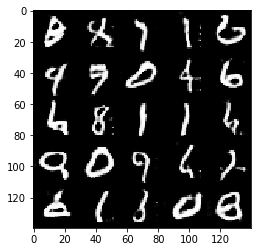


 Epoch 2/2 Step 2100 Discriminator Loss: 0.7793... Generator Loss: 1.5184

 Epoch 2/2 Step 2110 Discriminator Loss: 0.4553... Generator Loss: 2.5305

 Epoch 2/2 Step 2120 Discriminator Loss: 0.6183... Generator Loss: 1.5355

 Epoch 2/2 Step 2130 Discriminator Loss: 0.7013... Generator Loss: 1.3072

 Epoch 2/2 Step 2140 Discriminator Loss: 0.5664... Generator Loss: 2.0969

 Epoch 2/2 Step 2150 Discriminator Loss: 0.4782... Generator Loss: 2.6300

 Epoch 2/2 Step 2160 Discriminator Loss: 0.4516... Generator Loss: 2.2044

 Epoch 2/2 Step 2170 Discriminator Loss: 0.5135... Generator Loss: 2.6533

 Epoch 2/2 Step 2180 Discriminator Loss: 0.5701... Generator Loss: 2.0991

 Epoch 2/2 Step 2190 Discriminator Loss: 0.6643... Generator Loss: 1.6201


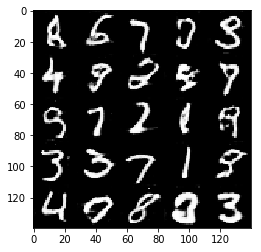


 Epoch 2/2 Step 2200 Discriminator Loss: 0.4224... Generator Loss: 2.5006

 Epoch 2/2 Step 2210 Discriminator Loss: 0.7623... Generator Loss: 1.2803

 Epoch 2/2 Step 2220 Discriminator Loss: 0.5364... Generator Loss: 1.8489

 Epoch 2/2 Step 2230 Discriminator Loss: 0.5430... Generator Loss: 1.9630

 Epoch 2/2 Step 2240 Discriminator Loss: 0.4370... Generator Loss: 3.4205

 Epoch 2/2 Step 2250 Discriminator Loss: 0.4069... Generator Loss: 3.0752

 Epoch 2/2 Step 2260 Discriminator Loss: 1.1658... Generator Loss: 1.0822

 Epoch 2/2 Step 2270 Discriminator Loss: 0.5733... Generator Loss: 1.9684

 Epoch 2/2 Step 2280 Discriminator Loss: 1.6923... Generator Loss: 4.1963

 Epoch 2/2 Step 2290 Discriminator Loss: 0.6254... Generator Loss: 1.6041


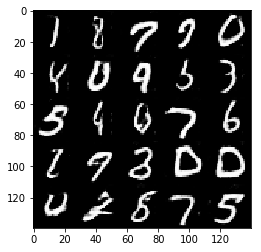


 Epoch 2/2 Step 2300 Discriminator Loss: 0.4708... Generator Loss: 2.6590

 Epoch 2/2 Step 2310 Discriminator Loss: 0.5438... Generator Loss: 2.2040

 Epoch 2/2 Step 2320 Discriminator Loss: 0.4352... Generator Loss: 2.7741

 Epoch 2/2 Step 2330 Discriminator Loss: 0.4974... Generator Loss: 2.8230

 Epoch 2/2 Step 2340 Discriminator Loss: 0.5047... Generator Loss: 3.4077

 Epoch 2/2 Step 2350 Discriminator Loss: 0.4417... Generator Loss: 2.2823

 Epoch 2/2 Step 2360 Discriminator Loss: 0.6024... Generator Loss: 2.5833

 Epoch 2/2 Step 2370 Discriminator Loss: 0.4598... Generator Loss: 2.6633

 Epoch 2/2 Step 2380 Discriminator Loss: 0.7648... Generator Loss: 1.6855

 Epoch 2/2 Step 2390 Discriminator Loss: 0.5274... Generator Loss: 3.9488


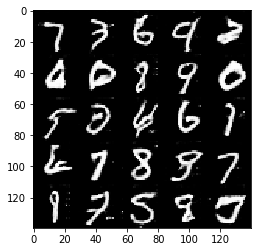


 Epoch 2/2 Step 2400 Discriminator Loss: 2.7013... Generator Loss: 6.4151

 Epoch 2/2 Step 2410 Discriminator Loss: 0.4999... Generator Loss: 1.9720

 Epoch 2/2 Step 2420 Discriminator Loss: 0.6881... Generator Loss: 1.9012

 Epoch 2/2 Step 2430 Discriminator Loss: 0.4988... Generator Loss: 2.1434

 Epoch 2/2 Step 2440 Discriminator Loss: 0.4605... Generator Loss: 2.6303

 Epoch 2/2 Step 2450 Discriminator Loss: 0.6304... Generator Loss: 1.7413

 Epoch 2/2 Step 2460 Discriminator Loss: 0.5321... Generator Loss: 2.0553

 Epoch 2/2 Step 2470 Discriminator Loss: 0.3987... Generator Loss: 3.3340

 Epoch 2/2 Step 2480 Discriminator Loss: 2.0158... Generator Loss: 0.4069

 Epoch 2/2 Step 2490 Discriminator Loss: 0.5323... Generator Loss: 1.7316


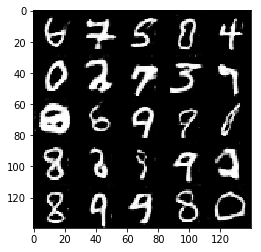


 Epoch 2/2 Step 2500 Discriminator Loss: 0.4839... Generator Loss: 2.3750

 Epoch 2/2 Step 2510 Discriminator Loss: 0.4459... Generator Loss: 2.6106

 Epoch 2/2 Step 2520 Discriminator Loss: 0.7430... Generator Loss: 1.5270

 Epoch 2/2 Step 2530 Discriminator Loss: 0.5157... Generator Loss: 2.1806

 Epoch 2/2 Step 2540 Discriminator Loss: 0.5667... Generator Loss: 1.9177

 Epoch 2/2 Step 2550 Discriminator Loss: 0.7095... Generator Loss: 2.2002

 Epoch 2/2 Step 2560 Discriminator Loss: 0.4910... Generator Loss: 2.5900

 Epoch 2/2 Step 2570 Discriminator Loss: 0.4721... Generator Loss: 2.5312

 Epoch 2/2 Step 2580 Discriminator Loss: 0.4063... Generator Loss: 2.7987

 Epoch 2/2 Step 2590 Discriminator Loss: 0.5997... Generator Loss: 1.8309


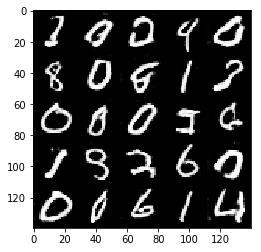


 Epoch 2/2 Step 2600 Discriminator Loss: 0.4218... Generator Loss: 3.1710

 Epoch 2/2 Step 2610 Discriminator Loss: 0.5097... Generator Loss: 2.1871

 Epoch 2/2 Step 2620 Discriminator Loss: 0.4956... Generator Loss: 3.2835

 Epoch 2/2 Step 2630 Discriminator Loss: 0.5385... Generator Loss: 3.3557

 Epoch 2/2 Step 2640 Discriminator Loss: 0.5634... Generator Loss: 1.9870

 Epoch 2/2 Step 2650 Discriminator Loss: 0.4811... Generator Loss: 2.6682

 Epoch 2/2 Step 2660 Discriminator Loss: 0.3865... Generator Loss: 3.2253

 Epoch 2/2 Step 2670 Discriminator Loss: 0.4023... Generator Loss: 4.1777

 Epoch 2/2 Step 2680 Discriminator Loss: 1.0376... Generator Loss: 1.1730

 Epoch 2/2 Step 2690 Discriminator Loss: 0.4675... Generator Loss: 2.7580


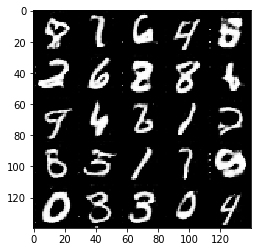


 Epoch 2/2 Step 2700 Discriminator Loss: 0.4473... Generator Loss: 2.5548

 Epoch 2/2 Step 2710 Discriminator Loss: 0.7242... Generator Loss: 1.5761

 Epoch 2/2 Step 2720 Discriminator Loss: 0.4353... Generator Loss: 2.8996

 Epoch 2/2 Step 2730 Discriminator Loss: 0.7395... Generator Loss: 1.6783

 Epoch 2/2 Step 2740 Discriminator Loss: 0.4426... Generator Loss: 2.2038

 Epoch 2/2 Step 2750 Discriminator Loss: 0.4062... Generator Loss: 2.9399

 Epoch 2/2 Step 2760 Discriminator Loss: 0.4862... Generator Loss: 2.9840

 Epoch 2/2 Step 2770 Discriminator Loss: 0.3933... Generator Loss: 3.6856

 Epoch 2/2 Step 2780 Discriminator Loss: 0.4670... Generator Loss: 1.9122

 Epoch 2/2 Step 2790 Discriminator Loss: 3.9061... Generator Loss: 0.1022


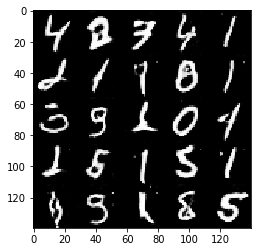


 Epoch 2/2 Step 2800 Discriminator Loss: 0.4453... Generator Loss: 2.5385

 Epoch 2/2 Step 2810 Discriminator Loss: 0.5021... Generator Loss: 2.6062

 Epoch 2/2 Step 2820 Discriminator Loss: 0.4180... Generator Loss: 2.7326

 Epoch 2/2 Step 2830 Discriminator Loss: 0.4294... Generator Loss: 3.2935

 Epoch 2/2 Step 2840 Discriminator Loss: 0.8579... Generator Loss: 1.3200

 Epoch 2/2 Step 2850 Discriminator Loss: 0.5950... Generator Loss: 3.5663

 Epoch 2/2 Step 2860 Discriminator Loss: 0.5183... Generator Loss: 1.7577

 Epoch 2/2 Step 2870 Discriminator Loss: 0.5408... Generator Loss: 1.9408

 Epoch 2/2 Step 2880 Discriminator Loss: 0.4688... Generator Loss: 3.2305

 Epoch 2/2 Step 2890 Discriminator Loss: 0.9834... Generator Loss: 3.2147


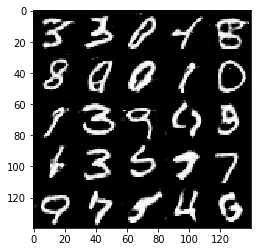


 Epoch 2/2 Step 2900 Discriminator Loss: 0.4583... Generator Loss: 2.6609

 Epoch 2/2 Step 2910 Discriminator Loss: 0.4011... Generator Loss: 3.3186

 Epoch 2/2 Step 2920 Discriminator Loss: 0.6090... Generator Loss: 3.5885

 Epoch 2/2 Step 2930 Discriminator Loss: 0.5799... Generator Loss: 1.6202

 Epoch 2/2 Step 2940 Discriminator Loss: 0.6923... Generator Loss: 1.7741

 Epoch 2/2 Step 2950 Discriminator Loss: 0.3806... Generator Loss: 4.6415

 Epoch 2/2 Step 2960 Discriminator Loss: 0.5331... Generator Loss: 3.0025

 Epoch 2/2 Step 2970 Discriminator Loss: 0.5789... Generator Loss: 3.2976

 Epoch 2/2 Step 2980 Discriminator Loss: 0.4239... Generator Loss: 2.3454

 Epoch 2/2 Step 2990 Discriminator Loss: 0.4584... Generator Loss: 3.6521


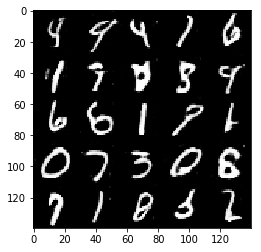


 Epoch 2/2 Step 3000 Discriminator Loss: 0.5005... Generator Loss: 2.8594

 Epoch 2/2 Step 3010 Discriminator Loss: 0.4373... Generator Loss: 2.5533

 Epoch 2/2 Step 3020 Discriminator Loss: 0.4288... Generator Loss: 3.0987

 Epoch 2/2 Step 3030 Discriminator Loss: 0.4274... Generator Loss: 2.7478

 Epoch 2/2 Step 3040 Discriminator Loss: 0.4554... Generator Loss: 2.9484

 Epoch 2/2 Step 3050 Discriminator Loss: 1.3865... Generator Loss: 0.9943

 Epoch 2/2 Step 3060 Discriminator Loss: 0.4321... Generator Loss: 2.1691

 Epoch 2/2 Step 3070 Discriminator Loss: 0.4585... Generator Loss: 2.6197

 Epoch 2/2 Step 3080 Discriminator Loss: 0.4190... Generator Loss: 3.4709

 Epoch 2/2 Step 3090 Discriminator Loss: 0.5889... Generator Loss: 2.7551


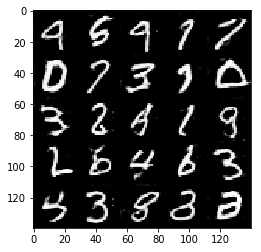


 Epoch 2/2 Step 3100 Discriminator Loss: 0.6243... Generator Loss: 1.6913

 Epoch 2/2 Step 3110 Discriminator Loss: 0.4243... Generator Loss: 2.6280

 Epoch 2/2 Step 3120 Discriminator Loss: 0.4525... Generator Loss: 2.7237

 Epoch 2/2 Step 3130 Discriminator Loss: 0.3738... Generator Loss: 4.0380

 Epoch 2/2 Step 3140 Discriminator Loss: 0.4311... Generator Loss: 2.5745

 Epoch 2/2 Step 3150 Discriminator Loss: 0.4731... Generator Loss: 3.0157

 Epoch 2/2 Step 3160 Discriminator Loss: 0.3832... Generator Loss: 3.8197

 Epoch 2/2 Step 3170 Discriminator Loss: 0.4093... Generator Loss: 2.7561

 Epoch 2/2 Step 3180 Discriminator Loss: 0.5315... Generator Loss: 2.0401

 Epoch 2/2 Step 3190 Discriminator Loss: 0.6920... Generator Loss: 1.8218


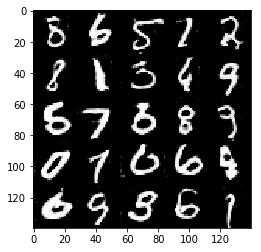


 Epoch 2/2 Step 3200 Discriminator Loss: 0.9648... Generator Loss: 1.0848

 Epoch 2/2 Step 3210 Discriminator Loss: 0.5092... Generator Loss: 2.7304

 Epoch 2/2 Step 3220 Discriminator Loss: 0.6537... Generator Loss: 1.7116

 Epoch 2/2 Step 3230 Discriminator Loss: 0.4156... Generator Loss: 3.1393

 Epoch 2/2 Step 3240 Discriminator Loss: 0.4042... Generator Loss: 3.7759

 Epoch 2/2 Step 3250 Discriminator Loss: 0.5802... Generator Loss: 1.9867

 Epoch 2/2 Step 3260 Discriminator Loss: 0.4090... Generator Loss: 3.0561

 Epoch 2/2 Step 3270 Discriminator Loss: 0.3871... Generator Loss: 3.5097

 Epoch 2/2 Step 3280 Discriminator Loss: 0.3912... Generator Loss: 3.8602

 Epoch 2/2 Step 3290 Discriminator Loss: 0.4821... Generator Loss: 2.3344


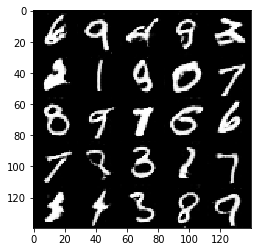


 Epoch 2/2 Step 3300 Discriminator Loss: 0.4981... Generator Loss: 2.4785

 Epoch 2/2 Step 3310 Discriminator Loss: 0.3924... Generator Loss: 3.7802

 Epoch 2/2 Step 3320 Discriminator Loss: 0.4088... Generator Loss: 3.7609

 Epoch 2/2 Step 3330 Discriminator Loss: 0.4875... Generator Loss: 4.2135

 Epoch 2/2 Step 3340 Discriminator Loss: 0.4421... Generator Loss: 3.2993

 Epoch 2/2 Step 3350 Discriminator Loss: 0.3993... Generator Loss: 3.2560

 Epoch 2/2 Step 3360 Discriminator Loss: 0.5091... Generator Loss: 4.2031

 Epoch 2/2 Step 3370 Discriminator Loss: 0.6914... Generator Loss: 2.3925

 Epoch 2/2 Step 3380 Discriminator Loss: 0.4890... Generator Loss: 1.9172

 Epoch 2/2 Step 3390 Discriminator Loss: 0.4248... Generator Loss: 3.0741


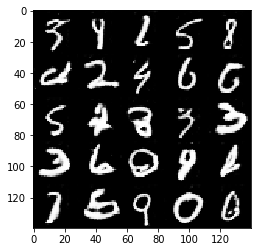


 Epoch 2/2 Step 3400 Discriminator Loss: 1.1880... Generator Loss: 4.0614

 Epoch 2/2 Step 3410 Discriminator Loss: 0.4136... Generator Loss: 3.0983

 Epoch 2/2 Step 3420 Discriminator Loss: 0.3829... Generator Loss: 3.3663

 Epoch 2/2 Step 3430 Discriminator Loss: 0.4016... Generator Loss: 3.4133

 Epoch 2/2 Step 3440 Discriminator Loss: 0.4882... Generator Loss: 2.9030

 Epoch 2/2 Step 3450 Discriminator Loss: 0.4637... Generator Loss: 2.5100

 Epoch 2/2 Step 3460 Discriminator Loss: 1.0909... Generator Loss: 1.0536

 Epoch 2/2 Step 3470 Discriminator Loss: 0.4043... Generator Loss: 3.1054

 Epoch 2/2 Step 3480 Discriminator Loss: 0.6848... Generator Loss: 4.2061

 Epoch 2/2 Step 3490 Discriminator Loss: 0.6651... Generator Loss: 3.3543


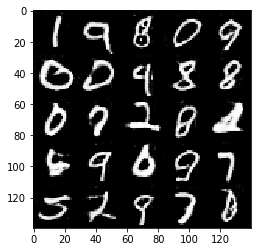


 Epoch 2/2 Step 3500 Discriminator Loss: 0.8251... Generator Loss: 1.1179

 Epoch 2/2 Step 3510 Discriminator Loss: 0.4079... Generator Loss: 3.2692

 Epoch 2/2 Step 3520 Discriminator Loss: 0.7195... Generator Loss: 1.9406

 Epoch 2/2 Step 3530 Discriminator Loss: 0.4244... Generator Loss: 3.7576

 Epoch 2/2 Step 3540 Discriminator Loss: 0.4012... Generator Loss: 3.2731

 Epoch 2/2 Step 3550 Discriminator Loss: 0.4014... Generator Loss: 3.6940

 Epoch 2/2 Step 3560 Discriminator Loss: 0.3884... Generator Loss: 3.8424

 Epoch 2/2 Step 3570 Discriminator Loss: 0.6500... Generator Loss: 1.7981

 Epoch 2/2 Step 3580 Discriminator Loss: 0.5662... Generator Loss: 2.2592

 Epoch 2/2 Step 3590 Discriminator Loss: 0.4125... Generator Loss: 3.1504


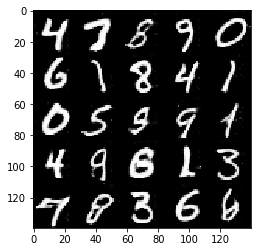


 Epoch 2/2 Step 3600 Discriminator Loss: 0.5908... Generator Loss: 4.1796

 Epoch 2/2 Step 3610 Discriminator Loss: 0.4469... Generator Loss: 3.6085

 Epoch 2/2 Step 3620 Discriminator Loss: 0.3894... Generator Loss: 2.7010

 Epoch 2/2 Step 3630 Discriminator Loss: 0.4491... Generator Loss: 3.1284

 Epoch 2/2 Step 3640 Discriminator Loss: 0.9707... Generator Loss: 1.6772

 Epoch 2/2 Step 3650 Discriminator Loss: 0.3922... Generator Loss: 3.3759

 Epoch 2/2 Step 3660 Discriminator Loss: 0.5074... Generator Loss: 2.6526

 Epoch 2/2 Step 3670 Discriminator Loss: 1.0256... Generator Loss: 5.0090

 Epoch 2/2 Step 3680 Discriminator Loss: 0.4471... Generator Loss: 3.0563

 Epoch 2/2 Step 3690 Discriminator Loss: 0.4138... Generator Loss: 3.5349


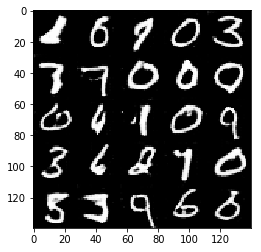


 Epoch 2/2 Step 3700 Discriminator Loss: 0.6418... Generator Loss: 2.1613

 Epoch 2/2 Step 3710 Discriminator Loss: 0.5135... Generator Loss: 2.6394

 Epoch 2/2 Step 3720 Discriminator Loss: 0.3783... Generator Loss: 3.3538

 Epoch 2/2 Step 3730 Discriminator Loss: 0.5248... Generator Loss: 2.0666

 Epoch 2/2 Step 3740 Discriminator Loss: 0.3814... Generator Loss: 3.8775

 Epoch 2/2 Step 3750 Discriminator Loss: 0.4475... Generator Loss: 3.1705

 Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 3.0321


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


 Epoch 1/1 Step 10 Discriminator Loss: 3.2506... Generator Loss: 0.0963

 Epoch 1/1 Step 20 Discriminator Loss: 0.7975... Generator Loss: 2.5456

 Epoch 1/1 Step 30 Discriminator Loss: 1.2914... Generator Loss: 4.6141

 Epoch 1/1 Step 40 Discriminator Loss: 1.3650... Generator Loss: 0.5198

 Epoch 1/1 Step 50 Discriminator Loss: 0.5794... Generator Loss: 2.3322

 Epoch 1/1 Step 60 Discriminator Loss: 0.5459... Generator Loss: 2.2068

 Epoch 1/1 Step 70 Discriminator Loss: 0.5063... Generator Loss: 3.0593

 Epoch 1/1 Step 80 Discriminator Loss: 0.4085... Generator Loss: 3.5115

 Epoch 1/1 Step 90 Discriminator Loss: 0.4339... Generator Loss: 3.0684


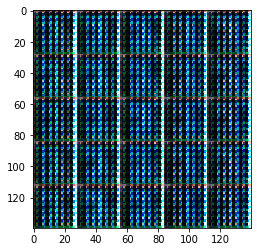


 Epoch 1/1 Step 100 Discriminator Loss: 0.5966... Generator Loss: 2.4300

 Epoch 1/1 Step 110 Discriminator Loss: 0.4436... Generator Loss: 2.6202

 Epoch 1/1 Step 120 Discriminator Loss: 0.5355... Generator Loss: 2.1331

 Epoch 1/1 Step 130 Discriminator Loss: 1.8744... Generator Loss: 4.6087

 Epoch 1/1 Step 140 Discriminator Loss: 0.9666... Generator Loss: 1.0088

 Epoch 1/1 Step 150 Discriminator Loss: 1.1056... Generator Loss: 1.5322

 Epoch 1/1 Step 160 Discriminator Loss: 1.6825... Generator Loss: 0.9177

 Epoch 1/1 Step 170 Discriminator Loss: 1.5949... Generator Loss: 0.5618

 Epoch 1/1 Step 180 Discriminator Loss: 1.1129... Generator Loss: 0.8974

 Epoch 1/1 Step 190 Discriminator Loss: 1.3706... Generator Loss: 0.9570


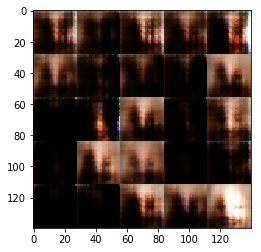


 Epoch 1/1 Step 200 Discriminator Loss: 1.5762... Generator Loss: 0.5878

 Epoch 1/1 Step 210 Discriminator Loss: 1.4976... Generator Loss: 0.6567

 Epoch 1/1 Step 220 Discriminator Loss: 1.4539... Generator Loss: 0.7426

 Epoch 1/1 Step 230 Discriminator Loss: 1.4589... Generator Loss: 0.7300

 Epoch 1/1 Step 240 Discriminator Loss: 1.7697... Generator Loss: 0.5964

 Epoch 1/1 Step 250 Discriminator Loss: 1.5681... Generator Loss: 0.6371

 Epoch 1/1 Step 260 Discriminator Loss: 1.5869... Generator Loss: 0.6514

 Epoch 1/1 Step 270 Discriminator Loss: 1.2042... Generator Loss: 0.9114

 Epoch 1/1 Step 280 Discriminator Loss: 1.5631... Generator Loss: 0.4998

 Epoch 1/1 Step 290 Discriminator Loss: 1.2266... Generator Loss: 0.9578


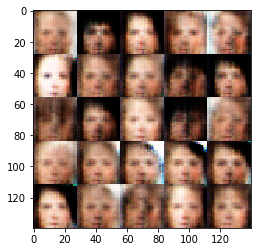


 Epoch 1/1 Step 300 Discriminator Loss: 1.3947... Generator Loss: 0.7946

 Epoch 1/1 Step 310 Discriminator Loss: 1.2386... Generator Loss: 0.7624

 Epoch 1/1 Step 320 Discriminator Loss: 1.2215... Generator Loss: 1.3716

 Epoch 1/1 Step 330 Discriminator Loss: 1.2399... Generator Loss: 0.7812

 Epoch 1/1 Step 340 Discriminator Loss: 1.4937... Generator Loss: 0.6893

 Epoch 1/1 Step 350 Discriminator Loss: 1.3911... Generator Loss: 0.6756

 Epoch 1/1 Step 360 Discriminator Loss: 1.6637... Generator Loss: 0.6123

 Epoch 1/1 Step 370 Discriminator Loss: 1.3940... Generator Loss: 0.7681

 Epoch 1/1 Step 380 Discriminator Loss: 1.1742... Generator Loss: 1.0711

 Epoch 1/1 Step 390 Discriminator Loss: 1.3788... Generator Loss: 0.6953


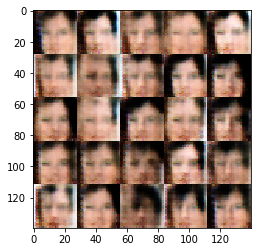


 Epoch 1/1 Step 400 Discriminator Loss: 1.3132... Generator Loss: 0.7670

 Epoch 1/1 Step 410 Discriminator Loss: 1.2846... Generator Loss: 0.7067

 Epoch 1/1 Step 420 Discriminator Loss: 1.4379... Generator Loss: 0.7976

 Epoch 1/1 Step 430 Discriminator Loss: 1.5196... Generator Loss: 0.5520

 Epoch 1/1 Step 440 Discriminator Loss: 1.6644... Generator Loss: 0.4323

 Epoch 1/1 Step 450 Discriminator Loss: 1.3495... Generator Loss: 0.7960

 Epoch 1/1 Step 460 Discriminator Loss: 1.4605... Generator Loss: 0.7430

 Epoch 1/1 Step 470 Discriminator Loss: 1.5178... Generator Loss: 1.0224

 Epoch 1/1 Step 480 Discriminator Loss: 1.5281... Generator Loss: 0.5909

 Epoch 1/1 Step 490 Discriminator Loss: 1.4600... Generator Loss: 1.0335


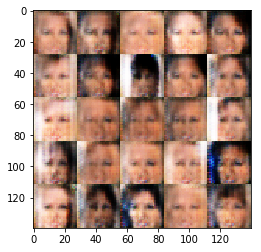


 Epoch 1/1 Step 500 Discriminator Loss: 1.3839... Generator Loss: 0.7518

 Epoch 1/1 Step 510 Discriminator Loss: 1.5038... Generator Loss: 0.5751

 Epoch 1/1 Step 520 Discriminator Loss: 1.5864... Generator Loss: 0.7360

 Epoch 1/1 Step 530 Discriminator Loss: 1.4227... Generator Loss: 0.7541

 Epoch 1/1 Step 540 Discriminator Loss: 1.3284... Generator Loss: 0.8116

 Epoch 1/1 Step 550 Discriminator Loss: 1.4961... Generator Loss: 0.6900

 Epoch 1/1 Step 560 Discriminator Loss: 1.3707... Generator Loss: 0.7858

 Epoch 1/1 Step 570 Discriminator Loss: 1.5594... Generator Loss: 0.5894

 Epoch 1/1 Step 580 Discriminator Loss: 1.5334... Generator Loss: 0.6215

 Epoch 1/1 Step 590 Discriminator Loss: 1.7396... Generator Loss: 0.3823


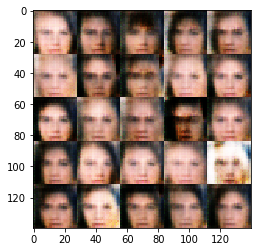


 Epoch 1/1 Step 600 Discriminator Loss: 1.5292... Generator Loss: 0.7243

 Epoch 1/1 Step 610 Discriminator Loss: 1.4542... Generator Loss: 0.7406

 Epoch 1/1 Step 620 Discriminator Loss: 1.4699... Generator Loss: 0.6610

 Epoch 1/1 Step 630 Discriminator Loss: 1.4211... Generator Loss: 0.7817

 Epoch 1/1 Step 640 Discriminator Loss: 1.4254... Generator Loss: 0.5586

 Epoch 1/1 Step 650 Discriminator Loss: 1.6347... Generator Loss: 0.5131

 Epoch 1/1 Step 660 Discriminator Loss: 1.6523... Generator Loss: 0.7818

 Epoch 1/1 Step 670 Discriminator Loss: 1.4976... Generator Loss: 0.7297

 Epoch 1/1 Step 680 Discriminator Loss: 1.4578... Generator Loss: 0.7721

 Epoch 1/1 Step 690 Discriminator Loss: 1.3567... Generator Loss: 0.7473


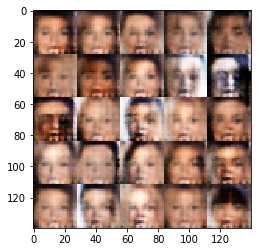


 Epoch 1/1 Step 700 Discriminator Loss: 1.5472... Generator Loss: 0.7482

 Epoch 1/1 Step 710 Discriminator Loss: 1.2851... Generator Loss: 0.7715

 Epoch 1/1 Step 720 Discriminator Loss: 1.5510... Generator Loss: 0.7323

 Epoch 1/1 Step 730 Discriminator Loss: 1.3755... Generator Loss: 0.8443

 Epoch 1/1 Step 740 Discriminator Loss: 1.3900... Generator Loss: 1.0044

 Epoch 1/1 Step 750 Discriminator Loss: 1.3495... Generator Loss: 0.9426

 Epoch 1/1 Step 760 Discriminator Loss: 1.3512... Generator Loss: 0.8173

 Epoch 1/1 Step 770 Discriminator Loss: 1.4441... Generator Loss: 0.7102

 Epoch 1/1 Step 780 Discriminator Loss: 1.4017... Generator Loss: 0.6873

 Epoch 1/1 Step 790 Discriminator Loss: 1.4372... Generator Loss: 0.7729


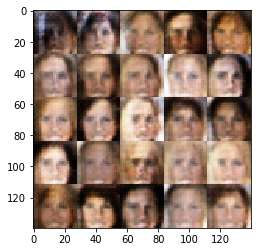


 Epoch 1/1 Step 800 Discriminator Loss: 1.3852... Generator Loss: 0.8505

 Epoch 1/1 Step 810 Discriminator Loss: 1.5303... Generator Loss: 0.5860

 Epoch 1/1 Step 820 Discriminator Loss: 1.4173... Generator Loss: 0.9397

 Epoch 1/1 Step 830 Discriminator Loss: 1.3812... Generator Loss: 0.7366

 Epoch 1/1 Step 840 Discriminator Loss: 1.4230... Generator Loss: 0.6443

 Epoch 1/1 Step 850 Discriminator Loss: 1.4632... Generator Loss: 0.7100

 Epoch 1/1 Step 860 Discriminator Loss: 1.5452... Generator Loss: 0.7225

 Epoch 1/1 Step 870 Discriminator Loss: 1.3538... Generator Loss: 0.7857

 Epoch 1/1 Step 880 Discriminator Loss: 1.3783... Generator Loss: 0.7096

 Epoch 1/1 Step 890 Discriminator Loss: 1.3937... Generator Loss: 0.9656


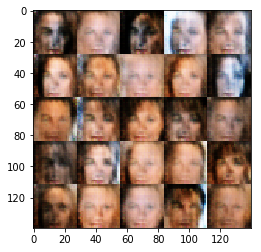


 Epoch 1/1 Step 900 Discriminator Loss: 1.4216... Generator Loss: 0.7417

 Epoch 1/1 Step 910 Discriminator Loss: 1.4421... Generator Loss: 0.7616

 Epoch 1/1 Step 920 Discriminator Loss: 1.4528... Generator Loss: 0.7056

 Epoch 1/1 Step 930 Discriminator Loss: 1.5030... Generator Loss: 0.7135

 Epoch 1/1 Step 940 Discriminator Loss: 1.5567... Generator Loss: 0.6043

 Epoch 1/1 Step 950 Discriminator Loss: 1.2797... Generator Loss: 0.8928

 Epoch 1/1 Step 960 Discriminator Loss: 1.2899... Generator Loss: 0.8914

 Epoch 1/1 Step 970 Discriminator Loss: 1.4436... Generator Loss: 0.5729

 Epoch 1/1 Step 980 Discriminator Loss: 1.3692... Generator Loss: 0.7417

 Epoch 1/1 Step 990 Discriminator Loss: 1.3243... Generator Loss: 0.8621


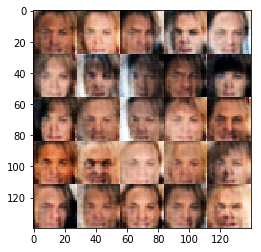


 Epoch 1/1 Step 1000 Discriminator Loss: 1.4309... Generator Loss: 0.8230

 Epoch 1/1 Step 1010 Discriminator Loss: 1.4310... Generator Loss: 0.6583

 Epoch 1/1 Step 1020 Discriminator Loss: 1.2574... Generator Loss: 0.8890

 Epoch 1/1 Step 1030 Discriminator Loss: 1.4847... Generator Loss: 0.7544

 Epoch 1/1 Step 1040 Discriminator Loss: 1.4797... Generator Loss: 0.6456

 Epoch 1/1 Step 1050 Discriminator Loss: 1.4466... Generator Loss: 0.6442

 Epoch 1/1 Step 1060 Discriminator Loss: 1.4879... Generator Loss: 0.5871

 Epoch 1/1 Step 1070 Discriminator Loss: 1.4716... Generator Loss: 0.7081

 Epoch 1/1 Step 1080 Discriminator Loss: 1.4119... Generator Loss: 0.7925

 Epoch 1/1 Step 1090 Discriminator Loss: 1.3271... Generator Loss: 0.6550


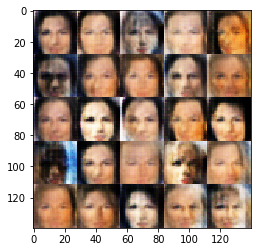


 Epoch 1/1 Step 1100 Discriminator Loss: 1.4249... Generator Loss: 0.6612

 Epoch 1/1 Step 1110 Discriminator Loss: 1.5766... Generator Loss: 0.6376

 Epoch 1/1 Step 1120 Discriminator Loss: 1.5872... Generator Loss: 0.5966

 Epoch 1/1 Step 1130 Discriminator Loss: 1.4811... Generator Loss: 0.7080

 Epoch 1/1 Step 1140 Discriminator Loss: 1.3673... Generator Loss: 0.7933

 Epoch 1/1 Step 1150 Discriminator Loss: 1.4052... Generator Loss: 0.6516

 Epoch 1/1 Step 1160 Discriminator Loss: 1.4062... Generator Loss: 0.7981

 Epoch 1/1 Step 1170 Discriminator Loss: 1.4237... Generator Loss: 0.7675

 Epoch 1/1 Step 1180 Discriminator Loss: 1.4500... Generator Loss: 0.6380

 Epoch 1/1 Step 1190 Discriminator Loss: 1.4325... Generator Loss: 0.7396


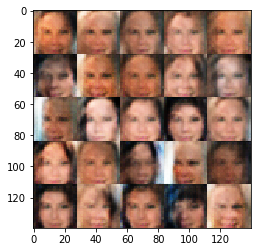


 Epoch 1/1 Step 1200 Discriminator Loss: 1.4675... Generator Loss: 0.7063

 Epoch 1/1 Step 1210 Discriminator Loss: 1.3580... Generator Loss: 0.7244

 Epoch 1/1 Step 1220 Discriminator Loss: 1.3121... Generator Loss: 0.7926

 Epoch 1/1 Step 1230 Discriminator Loss: 1.4161... Generator Loss: 0.8573

 Epoch 1/1 Step 1240 Discriminator Loss: 1.2820... Generator Loss: 1.2215

 Epoch 1/1 Step 1250 Discriminator Loss: 1.4659... Generator Loss: 0.7256

 Epoch 1/1 Step 1260 Discriminator Loss: 1.5338... Generator Loss: 0.5641

 Epoch 1/1 Step 1270 Discriminator Loss: 1.4059... Generator Loss: 0.7355

 Epoch 1/1 Step 1280 Discriminator Loss: 1.3580... Generator Loss: 0.9039

 Epoch 1/1 Step 1290 Discriminator Loss: 1.3321... Generator Loss: 0.8713


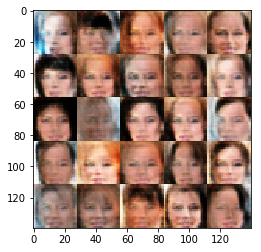


 Epoch 1/1 Step 1300 Discriminator Loss: 1.4096... Generator Loss: 0.7100

 Epoch 1/1 Step 1310 Discriminator Loss: 1.4258... Generator Loss: 0.6999

 Epoch 1/1 Step 1320 Discriminator Loss: 1.2150... Generator Loss: 0.9240

 Epoch 1/1 Step 1330 Discriminator Loss: 1.4832... Generator Loss: 0.5137

 Epoch 1/1 Step 1340 Discriminator Loss: 1.3114... Generator Loss: 0.7490

 Epoch 1/1 Step 1350 Discriminator Loss: 1.4249... Generator Loss: 0.6886

 Epoch 1/1 Step 1360 Discriminator Loss: 1.4384... Generator Loss: 0.6968

 Epoch 1/1 Step 1370 Discriminator Loss: 1.3991... Generator Loss: 0.6783

 Epoch 1/1 Step 1380 Discriminator Loss: 1.3152... Generator Loss: 0.7395

 Epoch 1/1 Step 1390 Discriminator Loss: 1.4528... Generator Loss: 0.6987


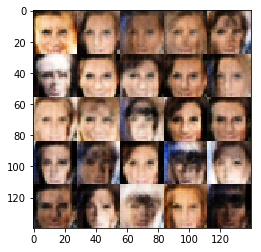


 Epoch 1/1 Step 1400 Discriminator Loss: 1.4427... Generator Loss: 0.7084

 Epoch 1/1 Step 1410 Discriminator Loss: 1.4470... Generator Loss: 0.7103

 Epoch 1/1 Step 1420 Discriminator Loss: 1.3898... Generator Loss: 0.6708

 Epoch 1/1 Step 1430 Discriminator Loss: 1.4331... Generator Loss: 0.7659

 Epoch 1/1 Step 1440 Discriminator Loss: 1.3654... Generator Loss: 0.8240

 Epoch 1/1 Step 1450 Discriminator Loss: 1.3406... Generator Loss: 0.7833

 Epoch 1/1 Step 1460 Discriminator Loss: 1.4199... Generator Loss: 0.6009

 Epoch 1/1 Step 1470 Discriminator Loss: 1.3682... Generator Loss: 0.7759

 Epoch 1/1 Step 1480 Discriminator Loss: 1.4944... Generator Loss: 0.6770

 Epoch 1/1 Step 1490 Discriminator Loss: 1.4167... Generator Loss: 0.6660


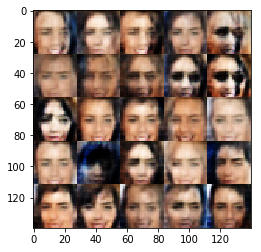


 Epoch 1/1 Step 1500 Discriminator Loss: 1.3693... Generator Loss: 0.7673

 Epoch 1/1 Step 1510 Discriminator Loss: 1.3529... Generator Loss: 0.7428

 Epoch 1/1 Step 1520 Discriminator Loss: 1.2590... Generator Loss: 0.8841

 Epoch 1/1 Step 1530 Discriminator Loss: 1.5105... Generator Loss: 0.5470

 Epoch 1/1 Step 1540 Discriminator Loss: 1.4200... Generator Loss: 0.8021

 Epoch 1/1 Step 1550 Discriminator Loss: 1.3328... Generator Loss: 0.7617

 Epoch 1/1 Step 1560 Discriminator Loss: 1.3833... Generator Loss: 0.8285

 Epoch 1/1 Step 1570 Discriminator Loss: 1.4632... Generator Loss: 0.7110

 Epoch 1/1 Step 1580 Discriminator Loss: 1.3531... Generator Loss: 0.7062

 Epoch 1/1 Step 1590 Discriminator Loss: 1.3309... Generator Loss: 0.7973


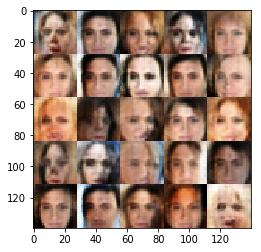


 Epoch 1/1 Step 1600 Discriminator Loss: 1.3926... Generator Loss: 0.6947

 Epoch 1/1 Step 1610 Discriminator Loss: 1.4198... Generator Loss: 0.5248

 Epoch 1/1 Step 1620 Discriminator Loss: 1.4119... Generator Loss: 0.6414

 Epoch 1/1 Step 1630 Discriminator Loss: 1.4097... Generator Loss: 0.6951

 Epoch 1/1 Step 1640 Discriminator Loss: 1.3865... Generator Loss: 0.6211

 Epoch 1/1 Step 1650 Discriminator Loss: 1.3400... Generator Loss: 0.7255

 Epoch 1/1 Step 1660 Discriminator Loss: 1.4964... Generator Loss: 0.6651

 Epoch 1/1 Step 1670 Discriminator Loss: 1.2614... Generator Loss: 1.0095

 Epoch 1/1 Step 1680 Discriminator Loss: 1.4284... Generator Loss: 0.7335

 Epoch 1/1 Step 1690 Discriminator Loss: 1.3770... Generator Loss: 0.9056


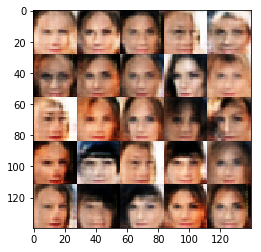


 Epoch 1/1 Step 1700 Discriminator Loss: 1.3888... Generator Loss: 0.5503

 Epoch 1/1 Step 1710 Discriminator Loss: 1.3997... Generator Loss: 0.6948

 Epoch 1/1 Step 1720 Discriminator Loss: 1.3678... Generator Loss: 0.6082

 Epoch 1/1 Step 1730 Discriminator Loss: 1.3762... Generator Loss: 0.7009

 Epoch 1/1 Step 1740 Discriminator Loss: 1.5171... Generator Loss: 0.5442

 Epoch 1/1 Step 1750 Discriminator Loss: 1.3349... Generator Loss: 0.7718

 Epoch 1/1 Step 1760 Discriminator Loss: 1.3278... Generator Loss: 0.5705

 Epoch 1/1 Step 1770 Discriminator Loss: 1.3522... Generator Loss: 0.7115

 Epoch 1/1 Step 1780 Discriminator Loss: 1.5098... Generator Loss: 0.7605

 Epoch 1/1 Step 1790 Discriminator Loss: 1.2934... Generator Loss: 0.7711


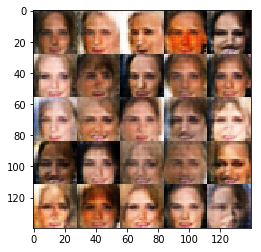


 Epoch 1/1 Step 1800 Discriminator Loss: 1.3531... Generator Loss: 0.8808

 Epoch 1/1 Step 1810 Discriminator Loss: 1.4424... Generator Loss: 0.5173

 Epoch 1/1 Step 1820 Discriminator Loss: 1.5323... Generator Loss: 0.4896

 Epoch 1/1 Step 1830 Discriminator Loss: 1.4311... Generator Loss: 0.8759

 Epoch 1/1 Step 1840 Discriminator Loss: 1.3666... Generator Loss: 0.6859

 Epoch 1/1 Step 1850 Discriminator Loss: 1.2945... Generator Loss: 0.7657

 Epoch 1/1 Step 1860 Discriminator Loss: 1.6125... Generator Loss: 0.5444

 Epoch 1/1 Step 1870 Discriminator Loss: 1.4984... Generator Loss: 0.6220

 Epoch 1/1 Step 1880 Discriminator Loss: 1.4517... Generator Loss: 0.6234

 Epoch 1/1 Step 1890 Discriminator Loss: 1.3076... Generator Loss: 0.8306


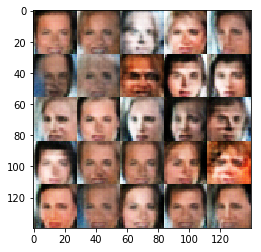


 Epoch 1/1 Step 1900 Discriminator Loss: 1.2270... Generator Loss: 1.1189

 Epoch 1/1 Step 1910 Discriminator Loss: 1.5240... Generator Loss: 0.6577

 Epoch 1/1 Step 1920 Discriminator Loss: 1.3456... Generator Loss: 0.9299

 Epoch 1/1 Step 1930 Discriminator Loss: 1.3421... Generator Loss: 0.8158

 Epoch 1/1 Step 1940 Discriminator Loss: 1.4436... Generator Loss: 1.0054

 Epoch 1/1 Step 1950 Discriminator Loss: 1.3354... Generator Loss: 0.8466

 Epoch 1/1 Step 1960 Discriminator Loss: 1.3635... Generator Loss: 0.8389

 Epoch 1/1 Step 1970 Discriminator Loss: 1.3787... Generator Loss: 0.7916

 Epoch 1/1 Step 1980 Discriminator Loss: 1.3885... Generator Loss: 0.8255

 Epoch 1/1 Step 1990 Discriminator Loss: 1.2953... Generator Loss: 0.8585


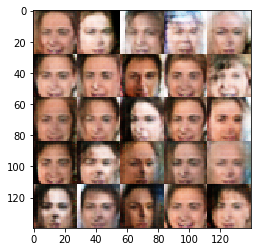


 Epoch 1/1 Step 2000 Discriminator Loss: 1.3476... Generator Loss: 0.7251

 Epoch 1/1 Step 2010 Discriminator Loss: 1.4005... Generator Loss: 0.8551

 Epoch 1/1 Step 2020 Discriminator Loss: 1.5162... Generator Loss: 0.5827

 Epoch 1/1 Step 2030 Discriminator Loss: 1.3160... Generator Loss: 0.8653

 Epoch 1/1 Step 2040 Discriminator Loss: 1.4071... Generator Loss: 0.6675

 Epoch 1/1 Step 2050 Discriminator Loss: 1.2732... Generator Loss: 0.9146

 Epoch 1/1 Step 2060 Discriminator Loss: 1.4838... Generator Loss: 0.5275

 Epoch 1/1 Step 2070 Discriminator Loss: 1.4025... Generator Loss: 1.1017

 Epoch 1/1 Step 2080 Discriminator Loss: 1.3137... Generator Loss: 0.7949

 Epoch 1/1 Step 2090 Discriminator Loss: 1.2061... Generator Loss: 1.1121


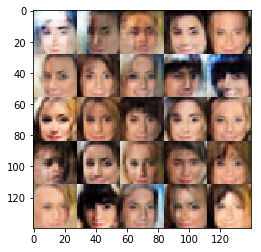


 Epoch 1/1 Step 2100 Discriminator Loss: 1.3999... Generator Loss: 0.7304

 Epoch 1/1 Step 2110 Discriminator Loss: 1.3659... Generator Loss: 0.7943

 Epoch 1/1 Step 2120 Discriminator Loss: 1.5265... Generator Loss: 0.5633

 Epoch 1/1 Step 2130 Discriminator Loss: 1.3442... Generator Loss: 0.6742

 Epoch 1/1 Step 2140 Discriminator Loss: 1.3035... Generator Loss: 0.8355

 Epoch 1/1 Step 2150 Discriminator Loss: 1.3836... Generator Loss: 0.6483

 Epoch 1/1 Step 2160 Discriminator Loss: 1.3361... Generator Loss: 0.8462

 Epoch 1/1 Step 2170 Discriminator Loss: 1.4819... Generator Loss: 0.5771

 Epoch 1/1 Step 2180 Discriminator Loss: 1.4676... Generator Loss: 0.7512

 Epoch 1/1 Step 2190 Discriminator Loss: 1.3643... Generator Loss: 0.8816


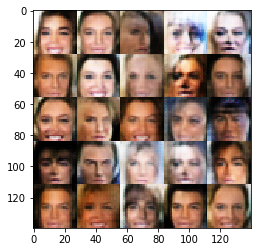


 Epoch 1/1 Step 2200 Discriminator Loss: 1.2812... Generator Loss: 0.7547

 Epoch 1/1 Step 2210 Discriminator Loss: 1.5093... Generator Loss: 0.5866

 Epoch 1/1 Step 2220 Discriminator Loss: 1.5122... Generator Loss: 1.0108

 Epoch 1/1 Step 2230 Discriminator Loss: 1.2945... Generator Loss: 0.9786

 Epoch 1/1 Step 2240 Discriminator Loss: 1.3767... Generator Loss: 0.8126

 Epoch 1/1 Step 2250 Discriminator Loss: 1.2142... Generator Loss: 1.0139

 Epoch 1/1 Step 2260 Discriminator Loss: 1.4223... Generator Loss: 0.7165

 Epoch 1/1 Step 2270 Discriminator Loss: 1.3436... Generator Loss: 0.8104

 Epoch 1/1 Step 2280 Discriminator Loss: 1.3089... Generator Loss: 1.0189

 Epoch 1/1 Step 2290 Discriminator Loss: 1.5337... Generator Loss: 0.4509


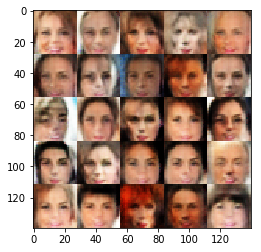


 Epoch 1/1 Step 2300 Discriminator Loss: 1.2921... Generator Loss: 0.8256

 Epoch 1/1 Step 2310 Discriminator Loss: 1.3267... Generator Loss: 0.7776

 Epoch 1/1 Step 2320 Discriminator Loss: 1.3028... Generator Loss: 0.7188

 Epoch 1/1 Step 2330 Discriminator Loss: 1.2980... Generator Loss: 0.9018

 Epoch 1/1 Step 2340 Discriminator Loss: 1.3493... Generator Loss: 1.1018

 Epoch 1/1 Step 2350 Discriminator Loss: 1.2932... Generator Loss: 1.2024

 Epoch 1/1 Step 2360 Discriminator Loss: 1.3967... Generator Loss: 0.7383

 Epoch 1/1 Step 2370 Discriminator Loss: 1.3384... Generator Loss: 0.7404

 Epoch 1/1 Step 2380 Discriminator Loss: 1.6762... Generator Loss: 0.3930

 Epoch 1/1 Step 2390 Discriminator Loss: 1.1706... Generator Loss: 0.9352


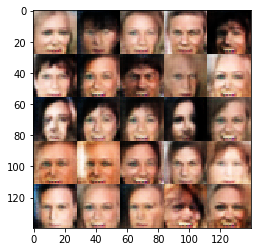


 Epoch 1/1 Step 2400 Discriminator Loss: 1.3153... Generator Loss: 1.0194

 Epoch 1/1 Step 2410 Discriminator Loss: 1.3671... Generator Loss: 0.6588

 Epoch 1/1 Step 2420 Discriminator Loss: 1.2449... Generator Loss: 0.7754

 Epoch 1/1 Step 2430 Discriminator Loss: 1.3866... Generator Loss: 0.5748

 Epoch 1/1 Step 2440 Discriminator Loss: 1.4239... Generator Loss: 0.4969

 Epoch 1/1 Step 2450 Discriminator Loss: 1.4460... Generator Loss: 0.7581

 Epoch 1/1 Step 2460 Discriminator Loss: 1.3227... Generator Loss: 0.8420

 Epoch 1/1 Step 2470 Discriminator Loss: 1.3005... Generator Loss: 0.7802

 Epoch 1/1 Step 2480 Discriminator Loss: 1.2437... Generator Loss: 0.9185

 Epoch 1/1 Step 2490 Discriminator Loss: 1.3038... Generator Loss: 1.2374


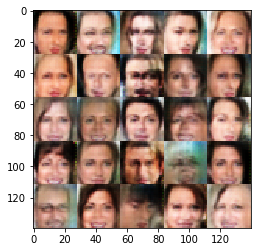


 Epoch 1/1 Step 2500 Discriminator Loss: 1.2157... Generator Loss: 1.2557

 Epoch 1/1 Step 2510 Discriminator Loss: 1.6063... Generator Loss: 1.2796

 Epoch 1/1 Step 2520 Discriminator Loss: 1.2814... Generator Loss: 0.8871

 Epoch 1/1 Step 2530 Discriminator Loss: 1.3345... Generator Loss: 0.7136

 Epoch 1/1 Step 2540 Discriminator Loss: 1.4434... Generator Loss: 0.5456

 Epoch 1/1 Step 2550 Discriminator Loss: 1.3960... Generator Loss: 1.4400

 Epoch 1/1 Step 2560 Discriminator Loss: 1.5740... Generator Loss: 0.5783

 Epoch 1/1 Step 2570 Discriminator Loss: 1.3242... Generator Loss: 1.0209

 Epoch 1/1 Step 2580 Discriminator Loss: 1.3642... Generator Loss: 0.9750

 Epoch 1/1 Step 2590 Discriminator Loss: 1.5456... Generator Loss: 0.9912


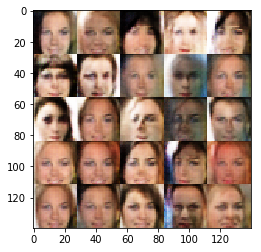


 Epoch 1/1 Step 2600 Discriminator Loss: 1.1801... Generator Loss: 0.8611

 Epoch 1/1 Step 2610 Discriminator Loss: 1.4935... Generator Loss: 0.8054

 Epoch 1/1 Step 2620 Discriminator Loss: 1.3398... Generator Loss: 0.7686

 Epoch 1/1 Step 2630 Discriminator Loss: 1.2447... Generator Loss: 0.8038

 Epoch 1/1 Step 2640 Discriminator Loss: 1.2448... Generator Loss: 0.9812

 Epoch 1/1 Step 2650 Discriminator Loss: 1.1665... Generator Loss: 0.7063

 Epoch 1/1 Step 2660 Discriminator Loss: 1.4484... Generator Loss: 0.7779

 Epoch 1/1 Step 2670 Discriminator Loss: 1.3315... Generator Loss: 0.9697

 Epoch 1/1 Step 2680 Discriminator Loss: 1.3540... Generator Loss: 0.6389

 Epoch 1/1 Step 2690 Discriminator Loss: 1.2107... Generator Loss: 0.7215


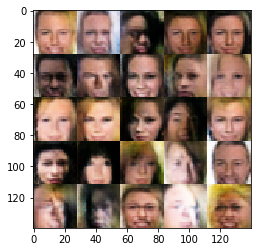


 Epoch 1/1 Step 2700 Discriminator Loss: 1.2808... Generator Loss: 0.7254

 Epoch 1/1 Step 2710 Discriminator Loss: 1.4975... Generator Loss: 0.4418


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.